In [1]:
!pip install gdown

In [2]:
!gdown 17wfzOhUKRIHQL6mNK67iLqJjLiTi3Pl6

Downloading...
From: https://drive.google.com/uc?id=17wfzOhUKRIHQL6mNK67iLqJjLiTi3Pl6
To: /content/Copy of FruitinAmazon.zip
100% 1.24M/1.24M [00:00<00:00, 121MB/s]


In [3]:
!unzip Copy\ of\ FruitinAmazon.zip

Archive:  Copy of FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating: FruitinAmazon/train/

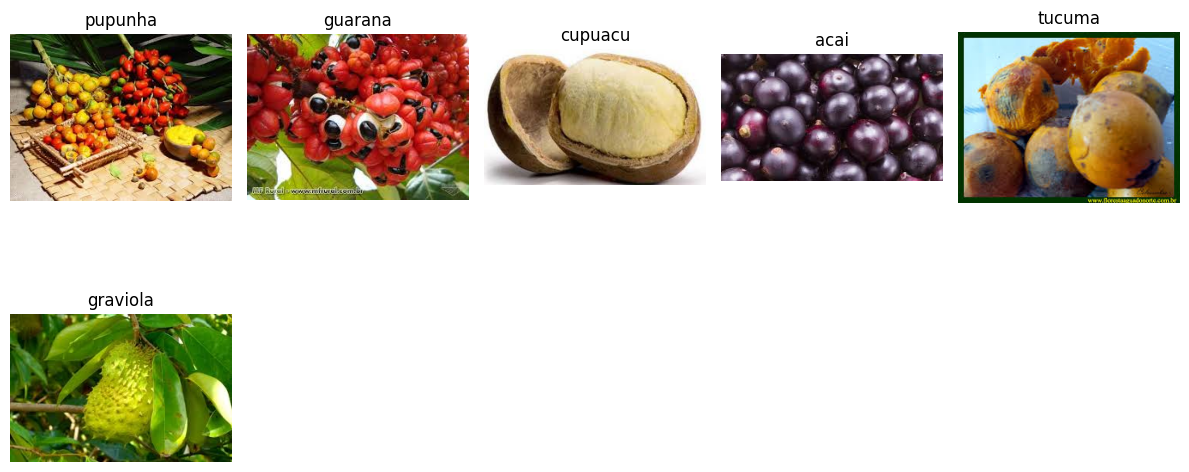

In [4]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Set your dataset path
train_dir = '/content/FruitinAmazon/train'

# Get class names
class_names = os.listdir(train_dir)

# Display random image from each class
plt.figure(figsize=(12, 6))
for i, fruit_class in enumerate(class_names[:10]):  # limit to 10 classes for visual clarity
    class_path = os.path.join(train_dir, fruit_class)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(fruit_class)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
from PIL import UnidentifiedImageError

corrupted = []

for fruit_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, fruit_class)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # verifies integrity
        except (UnidentifiedImageError, IOError, SyntaxError):
            print(f"Removed corrupted image: {img_path}")
            corrupted.append(img_path)
            os.remove(img_path)

if not corrupted:
    print("No corrupted images found.")

No corrupted images found.


In [14]:
class_counts = {}

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.png', '.jpeg'))]
    class_counts[class_name] = len(images)

print("\nClass Distribution:")
for k, v in class_counts.items():
    print(f"{k}: {v} images")



Class Distribution:
acai: 15 images
cupuacu: 15 images
graviola: 15 images
guarana: 15 images
pupunha: 15 images
tucuma: 15 images


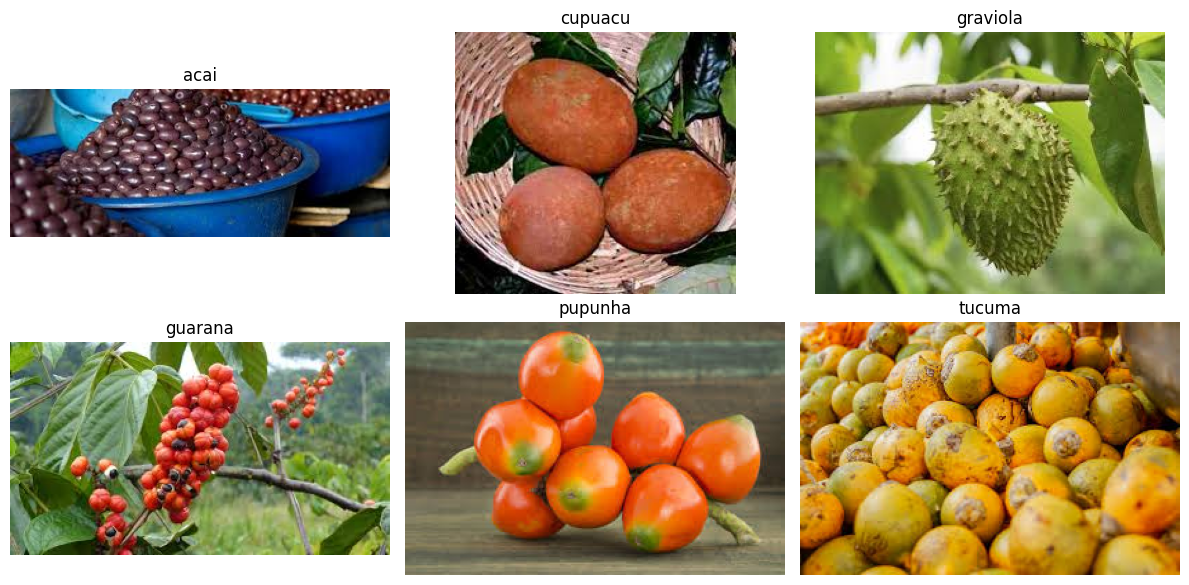

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    selected_images.append(os.path.join(class_path, img_name))
    selected_labels.append(class_name)

cols = (len(selected_images) + 1) // 2
fig, axes = plt.subplots(2, cols, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i])
        ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

# 1. Define augmentation + rescaling
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.Rescaling(1./255)
])

# 2. Load raw datasets
image_size = (224, 224)
batch_size = 32

raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# 3. Get class names
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# 4. Apply augmentation to train set only
train_ds = raw_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# 5. Apply rescaling only to val set
val_ds = val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

# ✅ 6. Add caching, shuffling, prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation

model = Sequential([
    layers.Input(shape=(224, 224, 3)),

    # Block 1
    Conv2D(32, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), padding='same', activation=None),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),
    Dense(512), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(128), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(64), BatchNormalization(), Activation('relu'), Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,04

 Total params: 26,257,670 (100.17 MB)

 Trainable params: 26,254,790 (100.15 MB)

 Non-trainable params: 2,880 (11.25 KB)

In [18]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


In [19]:
# Load unmodified dataset
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=8  # Small batch for easier visualization
)

# Get a batch (one batch = 8 images)
for images, labels in raw_train_ds.take(1):
    original_images = images
    augmented_images = data_augmentation(images)


Found 90 files belonging to 6 classes.
Using 72 files for training.


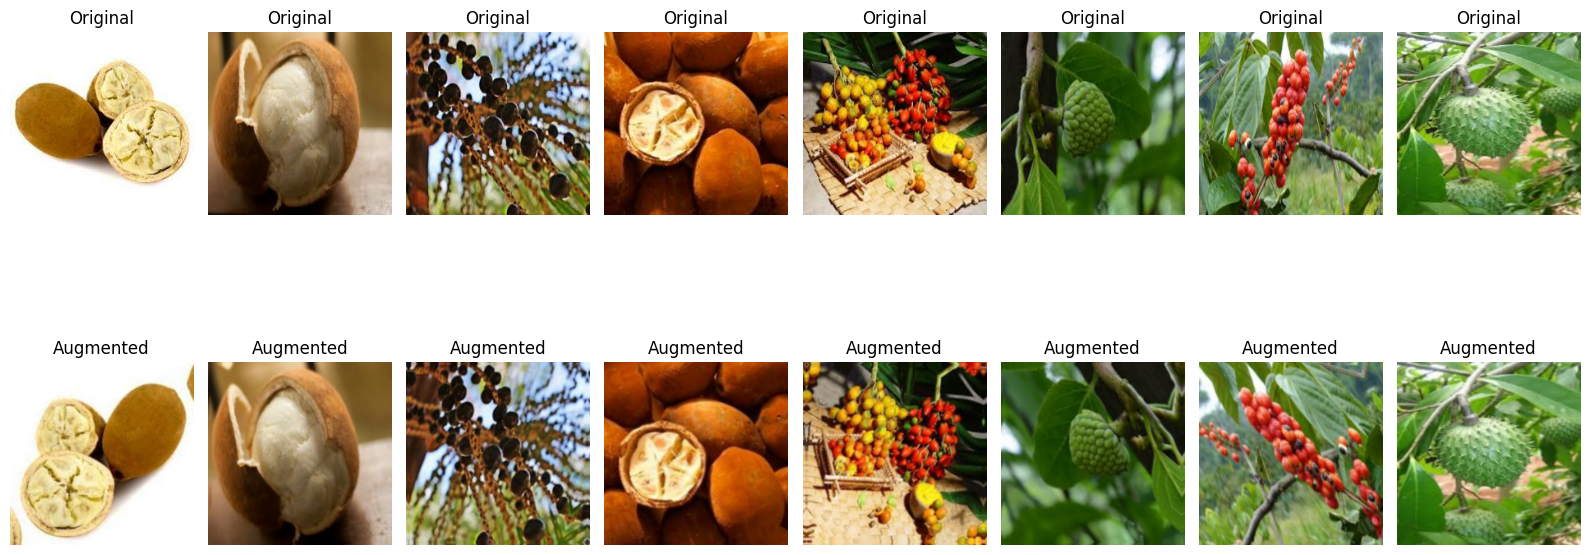

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

for i in range(8):
    # Original image
    plt.subplot(2, 8, i + 1)
    plt.imshow(original_images[i].numpy().astype("uint8"))
    plt.title("Original")
    plt.axis('off')

    # Augmented image
    plt.subplot(2, 8, i + 9)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title("Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)

test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 8s/step - accuracy: 0.1833 - loss: 2.4223 - val_accuracy: 0.0556 - val_loss: 1.8041
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.1141 - loss: 2.4826 - val_accuracy: 0.2778 - val_loss: 1.8085
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.2097 - loss: 2.2605 - val_accuracy: 0.2222 - val_loss: 1.8064
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.1747 - loss: 2.1404 - val_accuracy: 0.2222 - val_loss: 1.8112
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 5s/step - accuracy: 0.2244 - loss: 2.1531 - val_accuracy: 0.1667 - val_loss: 1.8154
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.2196 - loss: 2.1577 - val_accuracy: 0.2778 - val_loss: 1.8033
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 9s/step - accuracy: 0.1567 - loss: 2.0666 - val_accuracy: 0.2222 - val_loss: 1.7932
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.2422 - loss: 1.9255 - val_accuracy: 0.2222 - val_loss: 1.7869
Epoch 9/

In [22]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

# STEP 1: Load base model with frozen layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze everything initially

# STEP 2: Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

# STEP 3: Compile and train (Phase 1)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_vgg.fit(train_ds, validation_data=val_ds, epochs=10)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 50s 16s/step - accuracy: 0.1406 - loss: 1.8955 - val_accuracy: 0.2222 - val_loss: 1.9027
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 15s/step - accuracy: 0.4571 - loss: 1.6118 - val_accuracy: 0.3889 - val_loss: 1.7342
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 21s/step - accuracy: 0.4965 - loss: 1.3193 - val_accuracy: 0.3889 - val_loss: 1.6493
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 21s/step - accuracy: 0.7354 - loss: 1.0654 - val_accuracy: 0.4444 - val_loss: 1.5182
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 22s/step - accuracy: 0.8389 - loss: 0.9343 - val_accuracy: 0.5000 - val_loss: 1.4832
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 45s 15s/step - accuracy: 0.8182 - loss: 0.9510 - val_accuracy: 0.5556 - val_loss: 1.4591
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 47s 21s/step - accuracy: 0.8653 - loss: 0.7069 - val_accuracy: 0.5556 - val_loss: 1.4960
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 81s 15s/step - accuracy: 0.8043 - loss

In [23]:
# STEP 4: Unfreeze the last few layers
base_model.trainable = True
for layer in base_model.layers[:-4]:  # Freeze all except last 4
    layer.trainable = False

# STEP 5: Recompile with lower learning rate
model_vgg.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# STEP 6: Continue training (fine-tuning)
history_fine = model_vgg.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 61s 18s/step - accuracy: 0.9193 - loss: 0.5447 - val_accuracy: 0.5000 - val_loss: 1.4766
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 66s 23s/step - accuracy: 0.9036 - loss: 0.4787 - val_accuracy: 0.5000 - val_loss: 1.4904
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 18s/step - accuracy: 0.9370 - loss: 0.4016 - val_accuracy: 0.5000 - val_loss: 1.5000
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 18s/step - accuracy: 0.9440 - loss: 0.3580 - val_accuracy: 0.5000 - val_loss: 1.4976
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 25s/step - accuracy: 0.9604 - loss: 0.2168 - val_accuracy: 0.5000 - val_loss: 1.4946


In [24]:
model_vgg.fit(train_ds, validation_data=val_ds, epochs=10)

vgg_loss, vgg_acc = model_vgg.evaluate(val_ds)
print(f"VGG16 Transfer Learning Accuracy: {vgg_acc:.4f}")

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 25s/step - accuracy: 0.9792 - loss: 0.1702 - val_accuracy: 0.5000 - val_loss: 1.4927
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 56s 17s/step - accuracy: 0.9580 - loss: 0.2317 - val_accuracy: 0.5000 - val_loss: 1.4873
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 26s/step - accuracy: 0.9861 - loss: 0.1230 - val_accuracy: 0.5000 - val_loss: 1.4882
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 18s/step - accuracy: 0.9580 - loss: 0.1693 - val_accuracy: 0.5000 - val_loss: 1.4861
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 25s/step - accuracy: 0.9868 - loss: 0.0994 - val_accuracy: 0.5000 - val_loss: 1.4884
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 84s 25s/step - accuracy: 1.0000 - loss: 0.0850 - val_accuracy: 0.5000 - val_loss: 1.4928
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 80s 25s/step - accuracy: 1.0000 - loss: 0.0729 - val_accuracy: 0.5556 - val_loss: 1.5005
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 18s/step - accuracy: 1.0000 - loss: 0.0919 - val_accuracy: 0.5556 - val_loss: 1.5102


In [25]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels
y_true = np.concatenate([y for x, y in val_ds])

# Get predictions
y_pred_probs = model_vgg.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
              precision    recall  f1-score   support

        acai       1.00      0.33      0.50         3
     cupuacu       0.75      0.75      0.75         4
    graviola       1.00      1.00      1.00         1
     guarana       0.67      0.67      0.67         3
     pupunha       0.25      0.25      0.25         4
      tucuma       0.40      0.67      0.50         3

    accuracy                           0.56        18
   macro avg       0.68      0.61      0.61        18
weighted avg       0.62      0.56      0.56        18

